## Initial Imports


In [1]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
import torch

# import dependencies for PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mlc.data.mnist.dataset import MNIST
from mlc.data.celeba_align.dataset import CelebaAlign
from mlc.util.model import load_checkpoint
import mlc

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
torch.cuda.get_device_capability()

2.6.0+cu118
True
11.8
90100


(5, 0)

## Creating Model

In [3]:
import argparse
from mlc.model.vae.model import VAE

# Create parser and add arguments
parser = argparse.ArgumentParser()
VAE.add_arguments(parser)

# Parse empty args to use all defaults
args = parser.parse_args([])

# Convert Namespace to dict
args_dict = vars(args)

# Instantiate model with args
model = VAE(args_dict)
model

C-VAE: init_dim=6, layer_dim=6, num_blocks=2


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (z_mu_transform): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (z_sigma_transform): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (decoder): Sequential(
    (0

In [4]:
from torchsummary import summary
print(summary(model,(3,256,256),device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 256, 256]             162
              ReLU-2          [-1, 6, 256, 256]               0
       BatchNorm2d-3          [-1, 6, 256, 256]              12
         MaxPool2d-4          [-1, 6, 128, 128]               0
            Conv2d-5          [-1, 6, 128, 128]             324
              ReLU-6          [-1, 6, 128, 128]               0
       BatchNorm2d-7          [-1, 6, 128, 128]              12
         MaxPool2d-8            [-1, 6, 64, 64]               0
            Conv2d-9            [-1, 6, 64, 64]             324
             ReLU-10            [-1, 6, 64, 64]               0
      BatchNorm2d-11            [-1, 6, 64, 64]              12
           Conv2d-12            [-1, 6, 64, 64]              36
           Conv2d-13            [-1, 6, 64, 64]              36
  ConvTranspose2d-14          [-1, 6, 1

In [5]:
%cd C:/Users/hss19/Documents/GitHub/ml-2025
save_path = "models/vae/6c_50e/latest/model_state.pt"
state_dict = torch.load(save_path)

model.load_state_dict(state_dict)

C:\Users\hss19\Documents\GitHub\ml-2025


<All keys matched successfully>

## Importing dataset

In [6]:
celeba = CelebaAlign({"scale":256})
validation_data = celeba.get_fold("validation")

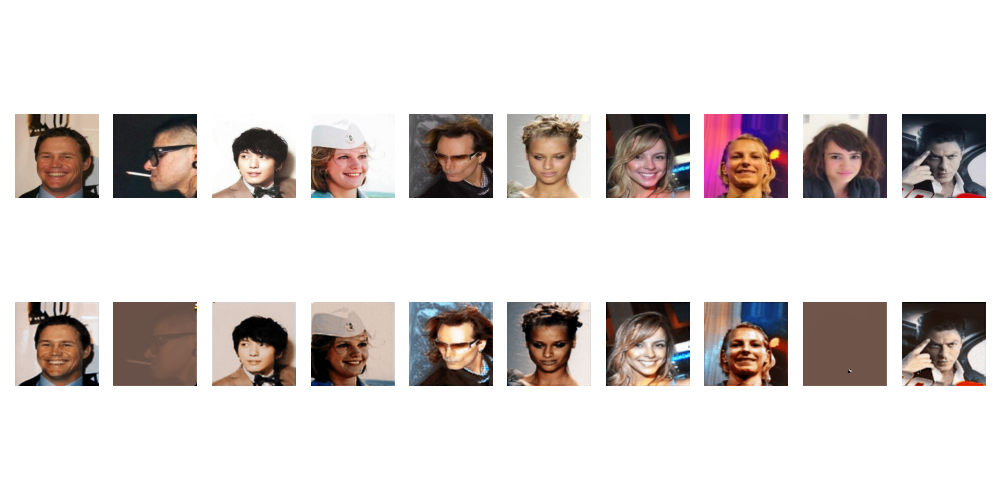

In [25]:
fig, ax = plt.subplots(2, 10, figsize=(10, 5), sharey=True)
# show some data
for i in range(10):
    data, _ = validation_data[i]
    with torch.no_grad():
        data = data.unsqueeze(0)
        data_rec = model(data)

        data = data.cpu().squeeze().permute(1,2,0).numpy()
        data_rec = data_rec.cpu().squeeze().permute(1,2,0).numpy()

    ax[0, i].imshow(data)
    ax[0, i].axis("off")
    # apply model
    ax[1, i].imshow(data_rec)
    ax[1, i].axis("off")

plt.tight_layout() 
plt.show()

## Test...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.717062..2.922658].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.428087..-2.2509367].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.103661..7.9245815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.952332..3.9661663].


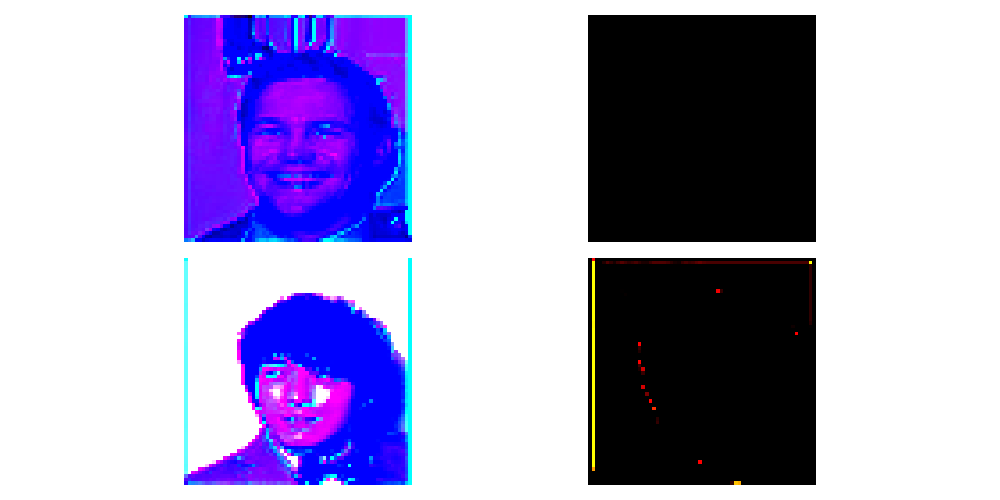

In [72]:
data00, _ = validation_data[0]
data02, _ = validation_data[2]

with torch.no_grad():
    data00 = data00.unsqueeze(0)
    data02 = data02.unsqueeze(0)
    z00 = model.encoder(data00)
    z02 = model.encoder(data02)

    z00_mu = model.z_mu_transform(z00)
    z00_sigma = model.z_sigma_transform(z00)
    z02_mu = model.z_mu_transform(z02)
    z02_sigma = model.z_sigma_transform(z02)

fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharey=True)
ax[0,0].imshow(z00_mu.cpu().squeeze().permute(1,2,0).numpy()[:,:,:3])
ax[0,1].imshow(z00_sigma.cpu().squeeze().permute(1,2,0).numpy()[:,:,:3])
ax[0,0].axis("off")
ax[0,1].axis("off")

ax[1,0].imshow(z02_mu.cpu().squeeze().permute(1,2,0).numpy()[:,:,:3])
ax[1,1].imshow(z02_sigma.cpu().squeeze().permute(1,2,0).numpy()[:,:,:3])
ax[1,0].axis("off")
ax[1,1].axis("off")

plt.tight_layout()
plt.show()



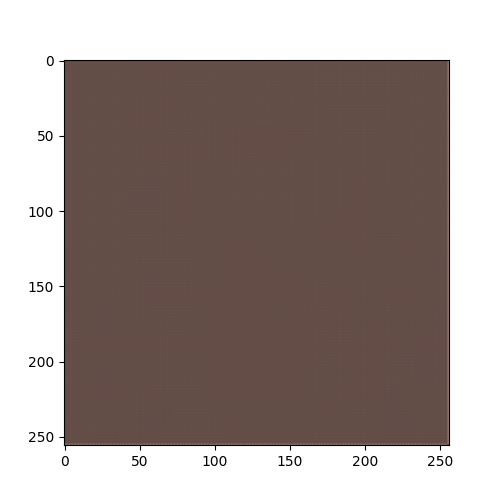

In [74]:
with torch.no_grad():
    img = model.decoder(z00_mu)
plt.figure(figsize=(5, 5))
plt.imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())


In [70]:
def interpolate_vae(model, image1, image2, steps=10):
    model.eval()
    with torch.no_grad():
        # Prepare images
        image1 = image1.unsqueeze(0) if image1.dim() == 3 else image1  # [1, C, H, W]
        image2 = image2.unsqueeze(0) if image2.dim() == 3 else image2


        # Encode to latent space
        z1 = model.encoder(image1)
        z2 = model.encoder(image2)

        z1_mu = model.z_mu_transform(z1)
        z2_mu = model.z_mu_transform(z2)

        # Or if encode returns mu only:
        # z1 = model.encode(image1)
        # z2 = model.encode(image2)

        # Linear interpolation between z1 and z2
        z_interp = torch.stack([
            z1_mu * (1 - alpha) + z2_mu * alpha
            for alpha in np.arange(steps+1)/steps
        ]).squeeze()  # shape: [steps, latent_dim]

        print(np.arange(steps+1)/steps)
        print(np.array(z_interp[0] - z1_mu).sum())
        # Decode to images
        recon_images = model.decoder(z_interp)  # returns [steps, C, H, W]

        # Plot
        fig, axes = plt.subplots(1, steps+1, figsize=(steps * 2, 2))
        for i in range(steps+1):
            img = recon_images[i].cpu().permute(1, 2, 0).numpy()
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

[0.   0.25 0.5  0.75 1.  ]
0.0


C:\Users\hss19\AppData\Local\Temp\ipykernel_15108\321647763.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(np.array(z_interp[0] - z1_mu).sum())


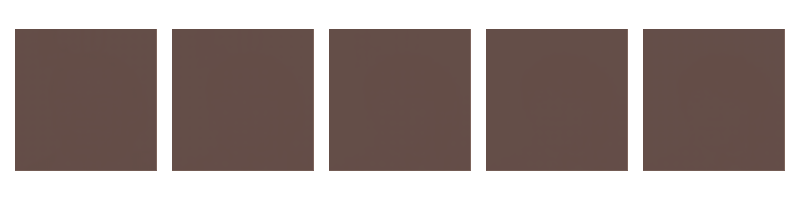

In [71]:
interpolate_vae(model, data00, data02, steps=4)

## Code...

In [ ]:
# apply encoder to data
encoded_data = []
label = []
for i in range(len(validation_data)):
    data, _ = validation_data[i]
    data = data.unsqueeze(0)
    with torch.no_grad():
        encoded = encoder(data)
        encoded_data.append(encoded.cpu().numpy())
        label.append(validation_data.get_label(i))
encoded_data = np.concatenate(encoded_data, axis=0)
label = np.array(label)
print(encoded_data.shape)
print(label.shape)

In [ ]:
# Do PCA on encoded data
pca = PCA(n_components=2)
pca.fit(encoded_data)
encoded_data_2d = pca.transform(encoded_data)
print(encoded_data_2d.shape)

In [ ]:
# scatter plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# scatter plot
for i in range(10):
    ax.scatter(encoded_data_2d[label == i, 0], encoded_data_2d[label == i, 1], alpha=0.5, label=f"Class {i}")
ax.legend()
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.show()

In [ ]:
# Do PCA on encoded data
pca = PCA(n_components=3)
pca.fit(encoded_data)
encoded_data_3d = pca.transform(encoded_data)
print(encoded_data_3d.shape)

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
# scatter plot
for i in range(10):
    ax.scatter(
        encoded_data_3d[label == i, 0],
        encoded_data_3d[label == i, 1],
        encoded_data_3d[label == i, 2],
        alpha=0.5,
        label=f"Class {i}",
    )
ax.legend()
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.show()

In [ ]:
# Use t-SNE to reduce the dimensionality of the data to 2D
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)
# Fit and transform the data
encoded_data_tsne = tsne.fit_transform(encoded_data)
print(encoded_data_tsne.shape)

In [ ]:
# Create a scatter plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# scatter plot
for i in range(10):
    ax.scatter(encoded_data_tsne[label == i, 0], encoded_data_tsne[label == i, 1], alpha=0.5, label=f"Class {i}")
ax.legend()
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
plt.show()

In [ ]:
# Use t-SNE to reduce the dimensionality of the data to 3D
# Initialize t-SNE
tsne = TSNE(n_components=3, random_state=42)
# Fit and transform the data
encoded_data_tsne_3d = tsne.fit_transform(encoded_data)
print(encoded_data_tsne_3d.shape)
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
# scatter plot
for i in range(10):
    ax.scatter(
        encoded_data_tsne_3d[label == i, 0],
        encoded_data_tsne_3d[label == i, 1],
        encoded_data_tsne_3d[label == i, 2],
        alpha=0.5,
        label=f"Class {i}",
    )
ax.legend()
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.show()